# The purpose of this is to provide a time-series forecast model to predict if the number of positives a country/territory will receive within the next number of days will increase or decrease

> data from: https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

In [1]:
# Import custom Time_Series python library and other imports
%run ./utils.ipynb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, GRU
from keras.optimizers import Adam
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import calendar

## Define model evaluations

In [2]:
models = {} # trained models
Ps_test = {} # post processed predictions
Ts_test = {} # post processed truths

# MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    aerror = np.zeros(y_true.shape, dtype=float)
    for i in range(y_true.shape[0]):
        if y_true[i] < 1:
            aerror[i] = y_pred[i]
        else:
            aerror[i] = np.abs((y_true[i] - y_pred[i]) / y_true[i])
    return np.mean(aerror)

# Measure how accurately model predicted if cases increase or decrease
def increase_decrease_accuracy(x_true, y_true, y_pred):
    n_correct = 0
    for i in range(y_true.shape[0]):
        if y_true[i] > x_true[i, -1]:
            if y_pred[i] > x_true[i, -1]:
                n_correct += 1
        elif y_true[i] < x_true[i, -1]:
            if y_pred[i] < x_true[i, -1]:
                n_correct += 1
    return n_correct / y_true.shape[0]

# plot and evalute model predictions
def evaluate(model_name, proc, X_test, Y_test, P_Test):
    r2 = r2_score(Y_test, P_Test)
    rmse = sqrt(mean_squared_error(Y_test, P_Test))
    mae = mean_absolute_error(Y_test, P_Test)
    mape = mean_absolute_percentage_error(Y_test, P_Test)
    ida = increase_decrease_accuracy(X_test, Y_test, P_Test)
    plt.scatter(np.log10(P_Test), np.log10(Y_test))
    max_order = int(max(np.log10(Y_test).max(), np.log10(P_Test).max())) + 2
    plt.plot([x for x in range(max_order)], [x for x in range(max_order)], color='green')
    plt.xticks(np.arange(0, max_order, 1))
    plt.yticks(np.arange(0, max_order, 1))
    plt.xlabel(r'log$_{10}$(Predicted)')
    plt.ylabel(r'log$_{10}$(Expected)')
    plt.title(model_name + ' ' + proc.title() + ' ' + r'Forecasts, $r^2$=' + str(round(r2, 4)))
    plt.show()
    print('r2', r2, 'rmse', rmse, 'mae', mae, 'mape', mape, 'ida', ida, '\n\n')

# add one month at a time

In [3]:
# define methods for forward and backward processing
reverses = {}
def preproc(base, name, func):
    Xs_train[name] = func(Xs_train[base])
    Ys_train[name] = func(Ys_train[base])
    Xs_test[name] = func(Xs_test[base])
    Ys_test[name] = func(Ys_test[base])
    for_ARIMA['train_' + name] = {}
    for country in for_ARIMA['train_' + base]:
        for_ARIMA['train_' + name][country] = func(for_ARIMA['train_' + base][country])
    for_ARIMA['test_' + name] = {}
    for country in for_ARIMA['test_' + base]:
        for_ARIMA['test_' + name][country] = func(for_ARIMA['test_' + base][country])

# raw
def reverse_raw(X):
    return X
reverses['raw'] = reverse_raw

# post_process model predictions by undoing processing and removing <1 values
def post_process(X, Y, P, proc):
    P = reverses[proc](P)
    drop_rows = [r for r in range(P.shape[0]) if P[r] <= 1]
    return np.delete(X, drop_rows, axis=0), np.delete(Y, drop_rows, axis=0), np.delete(P, drop_rows, axis=0)

05/01/2020 06/01/2020


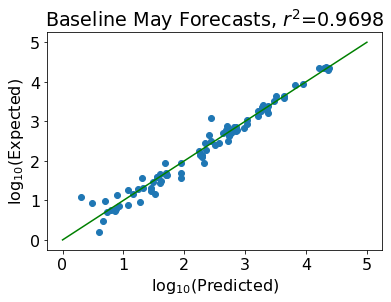

r2 0.9698499174116372 rmse 920.2035574495773 mae 300.5880952380953 mape 0.3058790685893084 ida 0.0 




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375.6192644416378, tolerance: 208.97478400000003
  model = cd_fast.enet_coordinate_descent(


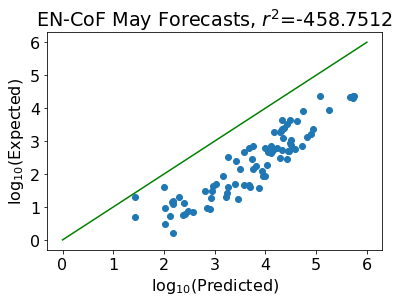

r2 -458.7512412375338 rmse 114211.51097559313 mae 39306.601826965874 mape 38.09177715714019 ida 0.42168674698795183 


06/01/2020 07/01/2020


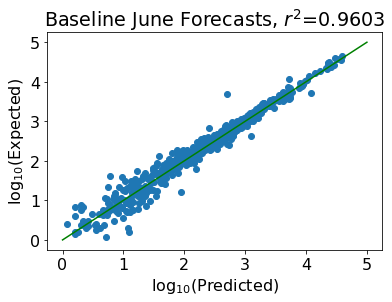

r2 0.9602714687361524 rmse 1004.6997124828173 mae 274.53617021276597 mape 0.31387828381185656 ida 0.0 




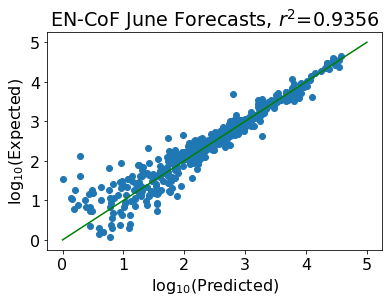

r2 0.9356299143261582 rmse 1320.8267393807896 mae 388.13221241096556 mape 0.45292489970932104 ida 0.5592515592515592 


07/01/2020 08/01/2020


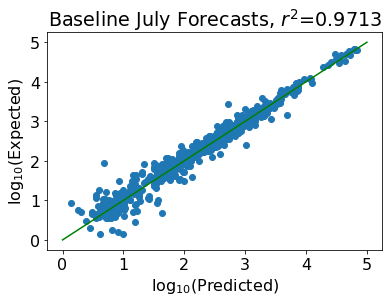

r2 0.9712593275969551 rmse 1361.8285509846398 mae 310.65569230769233 mape 0.3108390224862111 ida 0.0 




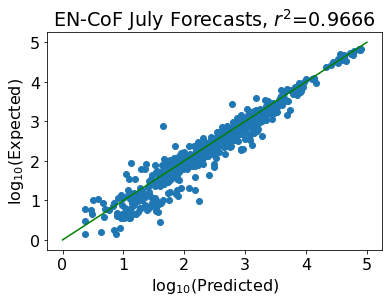

r2 0.9666202516725123 rmse 1480.6335430071763 mae 401.6505731589085 mape 0.6173274722909821 ida 0.5642633228840125 


08/01/2020 09/01/2020


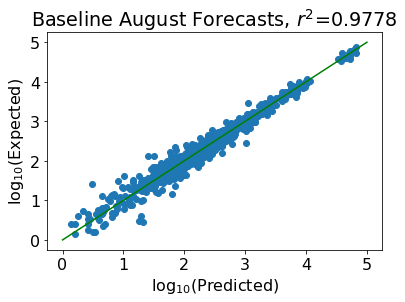

r2 0.9778167963127341 rmse 1219.8496678170397 mae 274.88519040902685 mape 0.2859924451264611 ida 0.0 




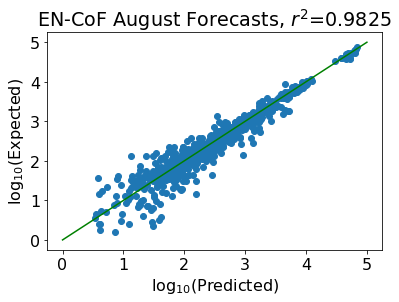

r2 0.9824874528239352 rmse 1113.0292409797976 mae 310.02344343696745 mape 0.5201517090416682 ida 0.5447761194029851 


09/01/2020 10/01/2020


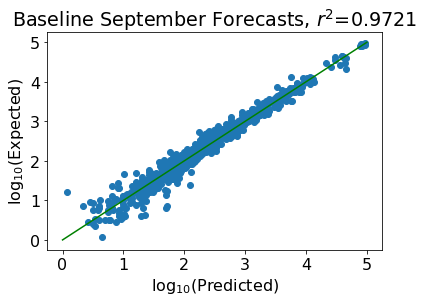

r2 0.9720901908921703 rmse 1501.3170593750172 mae 341.92321899736146 mape 0.28432647167483527 ida 0.0 




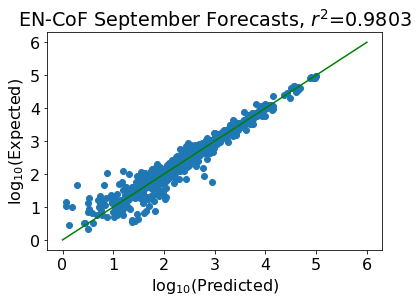

r2 0.9802876919163555 rmse 1287.5069638706643 mae 369.69666982692564 mape 0.42669732783351655 ida 0.5647382920110193 


10/01/2020 11/01/2020


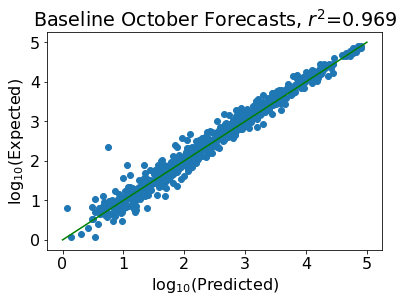

r2 0.968975785314907 rmse 1531.5364829845723 mae 513.4081048867699 mape 0.25684400197201634 ida 0.0 




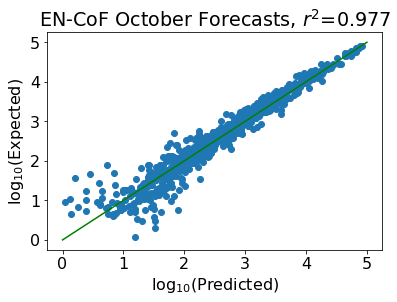

r2 0.9770194774123343 rmse 1335.954881244218 mae 477.20444013182305 mape 0.4283332219117148 ida 0.6117936117936118 


11/01/2020 12/01/2020


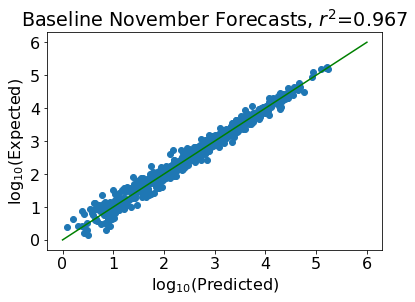

r2 0.9669599033109797 rmse 2545.228920946811 mae 674.249338146811 mape 0.24430485800431048 ida 0.0 




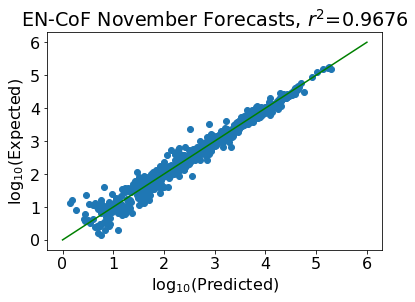

r2 0.9676124792848567 rmse 2536.8590923358333 mae 665.9570643177016 mape 0.29046083527242983 ida 0.645909645909646 




In [4]:
procs = ['raw']
for month in range(5, 12):
    str_train_start = '01/01/2020'
    str_train_end = ('0' if month < 10 else '') + str(month) + '/01/2020'
    str_test_start = str_train_end
    str_test_end = ('0' if month < 9 else '') +str(month + 1) + '/01/2020'
    print(str_train_end, str_test_end)

    start_train_date = pd.to_datetime(str_train_start) # start of train data
    end_train_date = pd.to_datetime(str_train_end) # end of train data
    start_test_date = pd.to_datetime(str_test_start) # start of train data
    end_test_date = pd.to_datetime(str_test_end) # end of train data
    k = 17 # number of n-day components
    n = 5 # n in n-day averages

    # read data
    data = readCOVID19('COVID-19-geographic-disbtribution-worldwide-2020-12-11.csv', days_min=100, cases_min=100)

    samples = {}
    # get trianing data (up to start_date)
    samples['train'], _ = prepare_MLA(data, window_size=n, lags=k, sample_name='train'
                                ,outputs=1, label_type='next', deriv=False
                                   , start_date=start_train_date, end_date=end_train_date)
    # get testing data (between start_date and end_date)
    samples['test'], _ = prepare_MLA(data, window_size=n, lags=k, sample_name='test'
                                ,outputs=1, label_type='next', deriv=False
                                  , start_date=start_test_date, end_date=end_test_date)

    # get X and Y for train and test
    Xs_train = {'raw': np.array(samples['train']['Xs'])}
    Ys_train = {'raw' : np.array(samples['train']['Ys']).flatten()}
    Xs_test = {'raw' : np.array(samples['test']['Xs'])}
    Ys_test = {'raw' : np.array(samples['test']['Ys']).flatten()}

    #### make predictions base on previous value
    model_name = 'Baseline'
    class Baseline:
        def predict(self, X):
            return X[:, -1]

    for proc in procs:

        # create and train model
        models[proc + '_' + model_name] = Baseline()

        # get predictions and post process
        returns = post_process(
            Xs_test['raw']
            , Ys_test['raw']
            , models[proc + '_' + model_name].predict(Xs_test[proc])
            , proc
        )
        Xs_test[proc + '_' + model_name] = returns[0]
        Ts_test[proc + '_' + model_name] = returns[1]
        Ps_test[proc + '_' + model_name] = returns[2]

        # evaluate model
        evaluate(
            model_name
            , calendar.month_name[month]
            , Xs_test[proc + '_' + model_name]
            , Ts_test[proc + '_' + model_name]
            , Ps_test[proc + '_' + model_name]
        )

    #### EN-CoF elastic net linear regression
    model_name = 'EN-CoF'

    for proc in procs:

        # create and train model
        models[proc + '_' + model_name] = ElasticNet(
            fit_intercept = False if proc == 'raw' else True
            , max_iter = 100000
        )
        models[proc + '_' + model_name].fit(Xs_train[proc], Ys_train[proc])

        # get predictions and post process
        returns = post_process(
            Xs_test['raw']
            , Ys_test['raw']
            , models[proc + '_' + model_name].predict(Xs_test[proc])
            , proc
        )
        Xs_test[proc + '_' + model_name] = returns[0]
        Ts_test[proc + '_' + model_name] = returns[1]
        Ps_test[proc + '_' + model_name] = returns[2]

        # evaluate model
        evaluate(
            model_name
            , calendar.month_name[month]
            , Xs_test[proc + '_' + model_name]
            , Ts_test[proc + '_' + model_name]
            , Ps_test[proc + '_' + model_name]
        )

        #write weights
        weights = models[proc + '_' + model_name].coef_
        with open('Output/' + calendar.month_name[month] + '_' + model_name + '_weights.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            for r in range(len(weights)):
                writer.writerow([len(weights)-r, weights[r]])